###########################################################################################################
#TRABAJO FINAL - METODOLOGIA DE LA ANALISIS PARA LA OPINION PUBLICA - CATEDRA: OLEGO
#AUTORES: MERCEDES PATRICIA LA ROSA SANTORO, TOMÁS PERLASCA, FRANCO CHIRICHELLA
#FECHA: 25/11/2025
###########################################################################################################

## 0. Importamos paquetes necesarios para el trabajo ####

In [1251]:
import pandas as pd #importamos pandas para los dataframes
import numpy  as np # pa los calculos numéricos
import matplotlib.pyplot as plt #pa los graficos
import seaborn as sns #pa los graficos
import scipy.stats as stats #pa los calculos estadisticos
import sklearn as sk #para la regresion logistica

## 1.Lectura del CSV ####

In [1252]:
pd.read_csv("encuestas_1000_casos.csv") #leemos el csv
df=pd.read_csv("encuestas_1000_casos.csv") #lo designamos a una dataframe
print (df) #mostramos el dataframe

          Fecha  Encuesta              Estrato       Sexo  Edad  \
0    2025-02-01       200              Tucumán  Masculino  42.0   
1    2025-03-01       400             San Luis  Masculino  36.0   
2    2025-03-01       400  Santiago del Estero  Masculino  26.0   
3    2025-03-01       400           Entre Ríos  Masculino  63.0   
4    2025-02-15       300           Entre Ríos  Masculino  37.0   
..          ...       ...                  ...        ...   ...   
995  2025-02-15       300           Santa Cruz  Masculino  60.0   
996  2025-02-01       200             La Pampa   Femenino  21.0   
997  2025-02-15       300  Santiago del Estero   Femenino  25.0   
998  2025-02-15       300           Corrientes  Masculino  70.0   
999  2025-03-01       400                Salta  Masculino  45.0   

                        Nivel Educativo  Cantidad de Integrantes en el Hogar  \
0                              Posgrado                                    1   
1                     Primario comp

## 2. Informacion general y limpieza de datos ####  

In [1253]:
print(df.isnull().sum()) #vemos cuantos nulos hay
print(df.columns.tolist()) #vemos las columnas como una lista
print(df.info()) #info general del df
[col for col in df.columns if "fecha" in col.lower()] #buscamos columna fecha para ver nombre exacto
#como la fecha va a ser lo que indexemos la unificamos antes que nada
df.columns = df.columns.str.lower().str.replace(" ","_") #normalizamos nombres columnas
df = df.drop_duplicates() #eliminamos filas duplicadas
print(df.columns.tolist()) #printeamos los cambios de nombres de las columnas
print(df.isnull().sum())  # vemos que no hay nulos
print(df.info()) # mostramos informacion del dataframe luego de la limpieza
print(df.describe())# mostramos estadisticas descriptivas del dataframe

Fecha                                   0
Encuesta                                0
Estrato                                 0
Sexo                                    0
Edad                                   48
Nivel Educativo                        21
Cantidad de Integrantes en el Hogar     0
Imagen del Candidato                    8
Voto                                   30
Voto Anterior                           0
dtype: int64
['Fecha', 'Encuesta', 'Estrato', 'Sexo', 'Edad', 'Nivel Educativo', 'Cantidad de Integrantes en el Hogar', 'Imagen del Candidato', 'Voto', 'Voto Anterior']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Fecha                                1000 non-null   object 
 1   Encuesta                             1000 non-null   int64  
 2   Estrato                             

## 3.Tracking imagen del candidato ####

In [1254]:
#como la fecha dice objets significa que la columna es string y no sirve para rolling por tiempo entonces:
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce') # convertimos la columna 'fecha' a tipo datetime
df = df.dropna(subset=['fecha']) #eliminamos filas donde 'fecha' no se pudo convertir  a datetime
#podemos llenar con la media o la moda en vez de eliminar nulos, pero en este caso no hay nulos en fecha, pero si puede ser en otras columnas para el analisis posterior
print(df.columns.tolist())
print(df["fecha"].dtype) #confirmamos que la fecha sea el formato correcto para poder aplicar rolling window
df["edad"] = df["edad"].astype("Int64")  # convertimos edad que era float a entero
print(df["edad"].dtype) #confirmamos que edad es int
df.set_index('fecha', inplace=True) #columna fecha como índice del df
df.sort_index(inplace=True) #ordenamos el df por el índice de fecha ya que es el "título" de cada fila
imagen_diaria = df["imagen_del_candidato"].resample("D").mean() #imagen x día
imagen_rolling = imagen_diaria.rolling("7D").mean()
print(imagen_rolling) #ahora si tenemos un dato por día, el promedio de todas las encuestas de ese día
# ahora podemos ver una fila por dia porque el rolling se aplica a un dato por dia que es la media diaria
# sirve en casos donde hay mas de una encuesta por dia

['fecha', 'encuesta', 'estrato', 'sexo', 'edad', 'nivel_educativo', 'cantidad_de_integrantes_en_el_hogar', 'imagen_del_candidato', 'voto', 'voto_anterior']
datetime64[ns]
Int64
fecha
2025-01-15    68.812500
2025-01-16    68.812500
2025-01-17    68.812500
2025-01-18    68.812500
2025-01-19    68.812500
2025-01-20    68.812500
2025-01-21    68.812500
2025-01-22          NaN
2025-01-23          NaN
2025-01-24          NaN
2025-01-25          NaN
2025-01-26          NaN
2025-01-27          NaN
2025-01-28          NaN
2025-01-29          NaN
2025-01-30          NaN
2025-01-31          NaN
2025-02-01    79.619048
2025-02-02    79.619048
2025-02-03    79.619048
2025-02-04    79.619048
2025-02-05    79.619048
2025-02-06    79.619048
2025-02-07    79.619048
2025-02-08          NaN
2025-02-09          NaN
2025-02-10          NaN
2025-02-11          NaN
2025-02-12          NaN
2025-02-13          NaN
2025-02-14          NaN
2025-02-15    65.969388
2025-02-16    65.969388
2025-02-17    65.969388
2

## 4.Tracking intencion de voto ####

In [1255]:
#buscamos dentro de la columna voto del dataframe el string que contenga ciertas caracterisiticas
# y si el caso es falso lo desestima y lo pone en default, para los casos true crea un nuevo data frame que se llama voto limpio
# el cual vamos a usar para hacer el resto de las funciones
df["voto_limpio"] = np.select(
    [
        df["voto"].str.contains("candidato a",case=False,na=False),
        df["voto"].str.contains("candidato b",case=False,na=False),
        df["voto"].str.contains("candidato c",case=False,na=False),
        df["voto"].str.contains("blanco",case=False, na=False),
        df["voto"].str.contains("vota",case=False, na=False),
    ],
    [
        "Candidato A",
        "Candidato B",
        "Candidato C",
        "En blanco",
        "No vota",
    ],
    default="Otro"
)
print(df["voto_limpio"])
conteo2 = df.groupby(['fecha','voto_limpio']).size().unstack(fill_value=0) # conteo diario de casos x candidato
totales = conteo2.sum(axis=1) # total casos x día
porcentaje_diario2 = conteo2.div(totales,axis=0)*100 # porcentaje diario de votos por candidato (fórmula V_C,t / N_t * 100)
porcentaje_rolling2 = porcentaje_diario2.rolling("7D").mean() # rolling window de 7 días que se puede ir modificando
print(porcentaje_rolling2.head())
porcentaje_diario2 = porcentaje_diario2.round(2)  #modificamos cantidad de decimales a 2
print(porcentaje_diario2.astype(str)+"%") # mostramos porcentajes diarios con símbolo % de cada candidato

fecha
2025-01-15    Candidato B
2025-01-15    Candidato B
2025-01-15    Candidato B
2025-01-15      En blanco
2025-01-15    Candidato A
                 ...     
2025-03-01    Candidato C
2025-03-01    Candidato C
2025-03-01    Candidato C
2025-03-01        No vota
2025-03-01        No vota
Name: voto_limpio, Length: 841, dtype: object
voto_limpio  Candidato A  Candidato B  Candidato C  En blanco    No vota  \
fecha                                                                      
2025-01-15     19.209040    25.423729    27.118644  20.903955   3.954802   
2025-02-01     20.158103    11.067194    14.624506  33.201581  18.577075   
2025-02-15     17.085427     4.020101    28.643216  14.070352  29.648241   
2025-03-01     22.641509    18.867925    19.339623  22.169811  14.622642   

voto_limpio      Otro  
fecha                  
2025-01-15   3.389831  
2025-02-01   2.371542  
2025-02-15   6.532663  
2025-03-01   2.358491  
voto_limpio Candidato A Candidato B Candidato C En blanco No 

## 5. VISUALIZACION ####

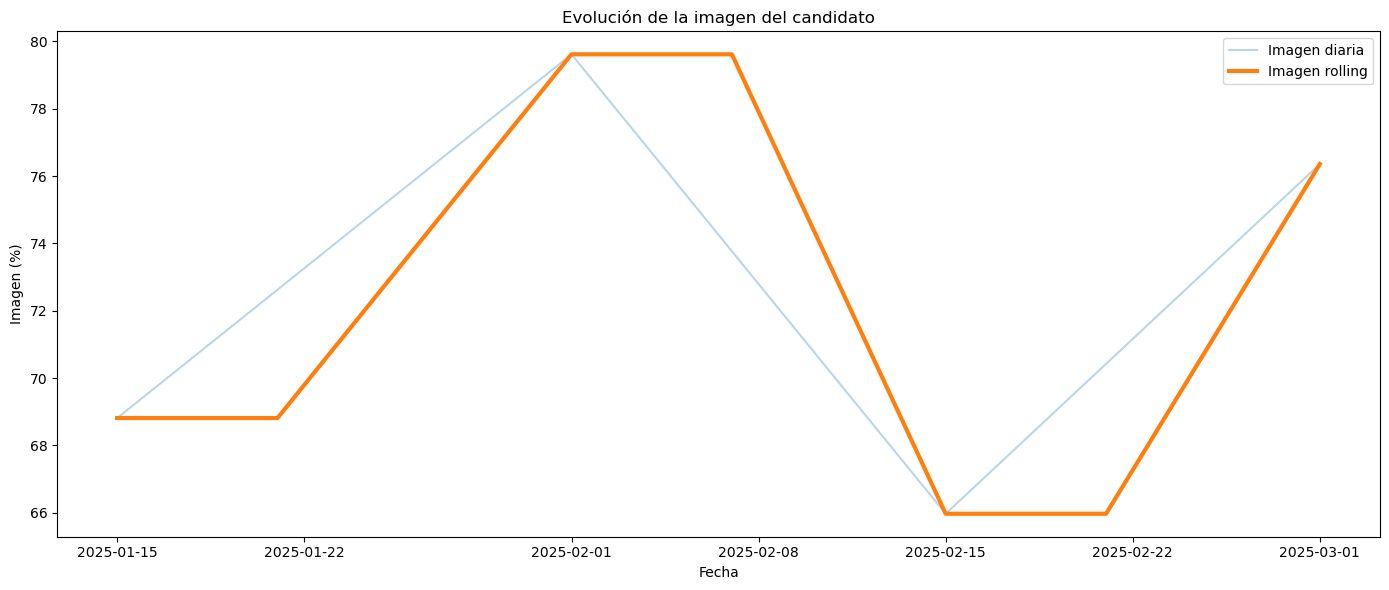

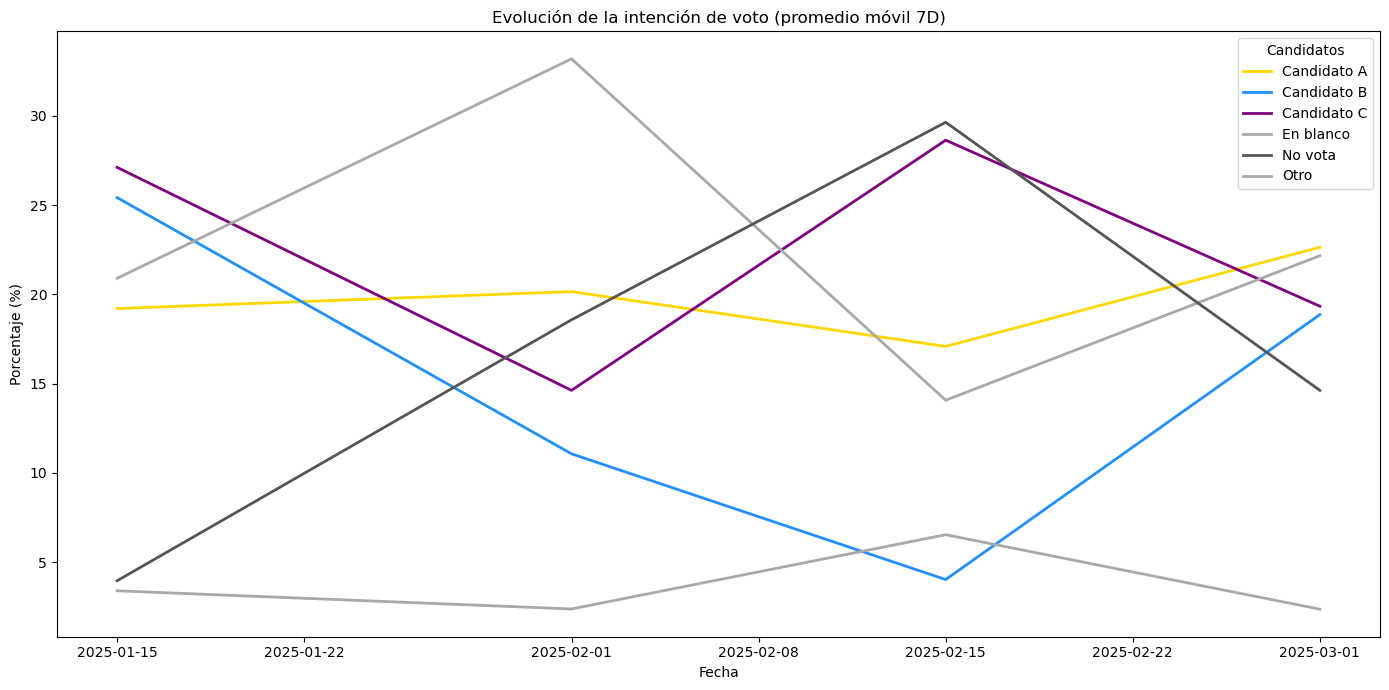

In [1256]:
#GRÁFICO DE LÍNEAS DE EVOLUCIÓN DE LA IMAGEN DEL CANDIDATO
plt.figure(figsize=(14, 6)) #definimos tamaño del grafico final
sns.lineplot( #linea 1
x=imagen_diaria.index, # x = fechas (el índice de la serie)
y=imagen_diaria, #y = valores diarios de imagen
label="Imagen diaria",
alpha=0.3 # transparencia de la línea
)
sns.lineplot( #linea 2
x=imagen_rolling.index,
y=imagen_rolling,
label="Imagen rolling", # El suavizado reduce picos artificiales de días atípicos
linewidth=3 #grosor línea
)
plt.title("Evolución de la imagen del candidato")
plt.xlabel("Fecha")
plt.ylabel("Imagen (%)")
plt.legend() # se muestra la "leyenda" para diferenciar líneas
plt.tight_layout() #ajuste layout para que nada quede fuera de frame
plt.show()

df_plot = porcentaje_rolling2.reset_index().melt( # Convertimos el df porcentaje_rolling2 formato "wide" a formato "long" para graficar múltiples líneas (1xcategoría)
id_vars="fecha", #columna fija, eje X del gráfico (las fechas, que varían)
var_name="categoria", # nombre de la variable/columna de las categorías
value_name="porcentaje" # nombre columna numerica, en este caso el rwolling de %
)
colores = {
    "Candidato A": "#FFD700",   # amarillo
    "Candidato B": "#1E90FF",   # celeste oscuro
    "Candidato C": "#800080",   # violeta
    "No vota":     "#555555",   # gris oscuro
    "En blanco":   "#A9A9A9",   # gris claro
    "Otro":        "#A9A9A9"    # para NS/NC o categorías residuales
}

# GRÁFICO DE LÍNEAS DE EVOLUCIÓN DE LA INTENCIÓN DE VOTO
plt.figure(figsize=(14, 7)) # definimos tamaño del grafico final
sns.lineplot(
    data=df_plot, # el df en formato long que preparamos con melt()
    x="fecha", #eje horizontal
    y="porcentaje", #eje vertical
    hue="categoria", # c/categoria de voto es cada linea
    linewidth=2, # grosor lineas
    palette=colores  #colores definidos arriba
)
plt.title("Evolución de la intención de voto (promedio móvil 7D)") #titulo
plt.xlabel("Fecha") #etiqueta eje x
plt.ylabel("Porcentaje (%)") #etiqueta eje y
plt.legend(title="Candidatos") #leyenda en el grafico
plt.tight_layout() #evitamos cortes del grafico y nombres con ajuste automatico del layout
plt.show()

## 6. Analisis Estadistico ####

## 6.1 Normalizacion de los datos de INDEC Censo 2022 y la Encuesta ###

In [1257]:

#ANALISIS ESTADISTICO
#6.1 Analisis estadistico - NORMALIZACION DE LOS DATOS DE INDEC CENSO 2022 y LA ENCUESTA

# en el dataframe de la encuesta vamos a eliminar los outliers de la columna edad (personas <16 y >95 años)
df_encuesta_estadistico = df[(df['edad'] >= 16) & (df['edad'] <= 95)] # filtramos edades validas
print(df_encuesta_estadistico['edad'].describe()) # mostramos estadisticas descriptivas de la columna edad luego de eliminar outliers
#la decision de realizarlo de esta manera y no por IQR es para eliminar por criterio logico
df_encuesta_estadistico = df_encuesta_estadistico.dropna() # eliminamos filas con nulos en edad si los hubiera

df_encuesta_estadistico.dtypes

# cargamos ahora el censo 2022 para poder ponderar las encuestas segun la poblacion real y adjuntarlo a la dataframe de las encuestas
pd.read_csv("censo_2022_v_final.csv") #leemos el csv del censo
df_censo=pd.read_csv("censo_2022_v_final.csv") #lo designamos a una dataframe
print (df_censo) #mostramos el dataframe del censo
print(df_censo.isnull().sum()) #vemos cuantos nulos hay en el censo
print(df_censo.columns.tolist()) #vemos las columnas del censo como una lista

# normalizamos nombres columnas del censo
df_censo.columns = df_censo.columns.str.lower().str.strip()
df_censo['estrato'] = df_censo['estrato'].str.lower().str.strip()
df_censo['sexo'] = df_censo['sexo'].str.lower().str.strip()

# normlizamos la encuesta tambien
df_encuesta_estadistico.columns = df_encuesta_estadistico.columns.str.lower().str.strip()
df_encuesta_estadistico['estrato'] = df_encuesta_estadistico['estrato'].str.lower().str.strip()
df_encuesta_estadistico['sexo'] = df_encuesta_estadistico['sexo'].str.lower().str.strip()

# calculamos el peso del censo
# población total del país según el archivo
poblacion_total = df_censo['poblacion'].sum()

# peso = proporción de población que representa ese grupo (estrato+sexo+edad)
df_censo['peso'] = df_censo['poblacion'] / poblacion_total

# esta es la tabla maestra que vamos a mergear
tabla_pesos = df_censo[['estrato','sexo','edad','peso']]
print(tabla_pesos)

# ahora mergeamos la tabla de pesos con el dataframe de encuestas

df_ponderado = pd.merge(df_encuesta_estadistico, tabla_pesos, how='left', left_on=['estrato','sexo','edad'], right_on=['estrato','sexo','edad'])
print(df_ponderado)


count        794.0
mean      47.77204
std      17.579427
min           18.0
25%           33.0
50%           46.0
75%           63.0
max           80.0
Name: edad, dtype: Float64
      codigo_estrato           estrato       sexo  edad  poblacion
0                  2              Caba   femenino    16      17153
1                  2              Caba  masculino    16      17213
2                  2              Caba   femenino    17      17923
3                  2              Caba  masculino    17      17905
4                  2              Caba   femenino    18      19907
...              ...               ...        ...   ...        ...
3995              23  Tierra del Fuego  masculino    93       6532
3996              23  Tierra del Fuego   femenino    94      13360
3997              23  Tierra del Fuego  masculino    94       4992
3998              23  Tierra del Fuego   femenino    95      10188
3999              23  Tierra del Fuego  masculino    95       3781

[4000 rows x 5 c

## 6.2 Moda, Mediana y Media ###

In [1258]:
#Calculamos las modas, medianas y medias de las variables

moda_edad = df_ponderado['edad'].mode()[0]
print("Moda de edad:", moda_edad)
moda_sexo = df_ponderado['sexo'].mode()[0]
print("Moda de sexo:", moda_sexo)
moda_estrato = df_ponderado['estrato'].mode()[0]
print("Moda de estrato:", moda_estrato)
moda_nivel_educativo = df_ponderado['nivel_educativo'].mode()[0]
print("Moda de nivel educativo:", moda_nivel_educativo)
moda_voto_limpio = df_ponderado['voto_limpio'].mode()[0]
print("Moda de voto limpio:", moda_voto_limpio)
moda_voto_anterior = df_ponderado['voto_anterior'].mode()[0]
print("Moda de voto anterior:", moda_voto_anterior)
moda_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].mode()[0]
print("Moda de cantidad de integrantes del hogar:", moda_cantidad_de_integrantes_hogar) 
moda_imagen_del_candidato = df_ponderado['imagen_del_candidato'].mode()[0]
print("Moda de imagen del candidato:", moda_imagen_del_candidato)

Moda de edad: 60
Moda de sexo: masculino
Moda de estrato: tierra del fuego
Moda de nivel educativo: Primario incompleto
Moda de voto limpio: En blanco
Moda de voto anterior: Candidato B
Moda de cantidad de integrantes del hogar: 2
Moda de imagen del candidato: 79.0


In [1259]:
#calculamos mediana de las varaibles, edad, cantidad de hogares e imagen del candidato
mediana_edad = df_ponderado['edad'].median()
print("Mediana de edad:", mediana_edad)
mediana_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].median()
print("Mediana de cantidad de integrantes del hogar:", mediana_cantidad_de_integrantes_hogar)
mediana_imagen_del_candidato = df_ponderado['imagen_del_candidato'].median()
print("Mediana de imagen del candidato:", mediana_imagen_del_candidato)

Mediana de edad: 46.0
Mediana de cantidad de integrantes del hogar: 3.0
Mediana de imagen del candidato: 78.0


In [1260]:
#calculamos la media arimetica y ponderada de la edad, cantidad de integrantes en el hogar e imagen del candidato

media_edad = df_ponderado['edad'].mean()
print("Media de edad:", round(media_edad, 2))
media_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].mean()
print("Media de cantidad de integrantes del hogar:", round(media_cantidad_de_integrantes_hogar, 2))
media_imagen_del_candidato = df_ponderado['imagen_del_candidato'].mean()
print("Media de imagen del candidato:", round(media_imagen_del_candidato, 2))
print( "-----------------------------------------------------------------------------------------")
media_edad_ponderado = np.average(df_ponderado['edad'], weights=df_ponderado['peso'])
print("Media ponderada de edad:", round(media_edad_ponderado, 2))
media_cantidad_de_integrantes_hogar_ponderado = np.average(df_ponderado['cantidad_de_integrantes_en_el_hogar'], weights=df_ponderado['peso'])   
print("Media ponderada de cantidad de integrantes del hogar:", round(media_cantidad_de_integrantes_hogar_ponderado, 2))
media_imagen_del_candidato_ponderado = np.average(df_ponderado['imagen_del_candidato'], weights=df_ponderado['peso'])
print("Media ponderada de imagen del candidato:", round(media_imagen_del_candidato_ponderado, 2))

Media de edad: 47.62
Media de cantidad de integrantes del hogar: 3.45
Media de imagen del candidato: 74.03
-----------------------------------------------------------------------------------------
Media ponderada de edad: 42.48
Media ponderada de cantidad de integrantes del hogar: 3.54
Media ponderada de imagen del candidato: 76.44


## 6.3 Cuartiles, calculo de varianza, desvio estandar, coeficiente de variacion numerica, rango y rango intercuantilico ###

In [1261]:
# cuartiles de las variables edad, cantidad de integrantes en el hogar e imagen del candidato
cuartiles_edad = df_ponderado['edad'].quantile([0.25, 0.5, 0.75])
print("Cuartiles de edad:\n", cuartiles_edad)
cuartiles_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].quantile([0.25, 0.5, 0.75])
print("Cuartiles de cantidad de integrantes del hogar:\n", cuartiles_cantidad_de_integrantes_hogar)
cuartiles_imagen_del_candidato = df_ponderado['imagen_del_candidato'].quantile([0.25, 0.5, 0.75])       
print("Cuartiles de imagen del candidato:\n", cuartiles_imagen_del_candidato)

Cuartiles de edad:
 0.25    33.0
0.50    46.0
0.75    63.0
Name: edad, dtype: Float64
Cuartiles de cantidad de integrantes del hogar:
 0.25    2.0
0.50    3.0
0.75    5.0
Name: cantidad_de_integrantes_en_el_hogar, dtype: float64
Cuartiles de imagen del candidato:
 0.25    61.0
0.50    78.0
0.75    89.0
Name: imagen_del_candidato, dtype: float64


In [1262]:
# Rango y rango intercuartilico (IQR)
# Cuartiles de las variables edad, cantidad de integrantes en el hogar e imagen del candidato
# El cuartil es una medida que nos sirve para poder dividir en partes igual observaciones para tener una mejor observacion de su dispersion
# Q1(0,25 indica que el 25% o menos #Q2(0,5 indica que el 50% o menos #Q3(0,75 indica que el 75% o menos #)
rango_edad = df_ponderado['edad'].max() - df_ponderado['edad'].min()
print("Rango de edad:", rango_edad)
rango_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].max() - df_ponderado['cantidad_de_integrantes_en_el_hogar'].min()
print("Rango de cantidad de integrantes del hogar:", rango_cantidad_de_integrantes_hogar)
rango_imagen_del_candidato = df_ponderado['imagen_del_candidato'].max() - df_ponderado['imagen_del_candidato'].min()
print("Rango de imagen del candidato:", rango_imagen_del_candidato)
print( "===================================================================")
iqr_edad = cuartiles_edad[0.75] - cuartiles_edad[0.25]
print("IQR de edad:", iqr_edad)
iqr_cantidad_de_integrantes_hogar = cuartiles_cantidad_de_integrantes_hogar[0.75] - cuartiles_cantidad_de_integrantes_hogar[0.25]
print("IQR de cantidad de integrantes del hogar:", iqr_cantidad_de_integrantes_hogar)
iqr_imagen_del_candidato = cuartiles_imagen_del_candidato[0.75] - cuartiles_imagen_del_candidato[0.25]
print("IQR de imagen del candidato:", iqr_imagen_del_candidato)


Rango de edad: 62
Rango de cantidad de integrantes del hogar: 5
Rango de imagen del candidato: 60.0
IQR de edad: 30.0
IQR de cantidad de integrantes del hogar: 3.0
IQR de imagen del candidato: 28.0


In [1263]:
# Desviacion estandar y varianza de las variables edad, cantidad de integrantes en el hogar e imagen del candidato
desvio_edad = df_ponderado['edad'].std()
print("Desviación estándar de edad:", round(desvio_edad, 2))
desvio_cantidad_de_integrantes_hogar = df_ponderado['cantidad_de_integrantes_en_el_hogar'].std()
print("Desviación estándar de cantidad de integrantes del hogar:", round(desvio_cantidad_de_integrantes_hogar, 2))
desvio_imagen_del_candidato = df_ponderado['imagen_del_candidato'].std()
print("Desviación estándar de imagen del candidato:", round(desvio_imagen_del_candidato, 2))
print( "==================================================================")
varianza_edad = df_ponderado['edad'].var()
print("Varianza de edad:", round(varianza_edad, 2))
varianza_cantidad_de_integrantes_hogar = df_ponderado["cantidad_de_integrantes_en_el_hogar"].var()
print("Varianza de cantidad de integrantes del hogar:", round(varianza_cantidad_de_integrantes_hogar, 2))
varianza_imagen_del_candidato = df_ponderado["imagen_del_candidato"].var()
print("Varianza de imagen del candidato:", round(varianza_imagen_del_candidato, 2))

#Desviacion estandar y varianza ponderada de las variables edad, cantidad de integrantes en el hogar e imagen del candidato
desvio_edad_ponderado = np.sqrt(np.cov(df_ponderado['edad'], aweights=df_ponderado['peso']))
print("Desviación estándar ponderada de edad:", round(desvio_edad_ponderado, 2))
Desvio_cantidad_de_integrantes_en_el_hogar_ponderado = np.sqrt(np.cov(df_ponderado ["cantidad_de_integrantes_en_el_hogar"], aweights=df_ponderado['peso']))
print("Desviación estándar ponderada de cantidad de integrantes del hogar:", round(Desvio_cantidad_de_integrantes_en_el_hogar_ponderado, 2))
desvio_imagen_del_candidato_ponderado = np.sqrt(np.cov(df_ponderado['imagen_del_candidato'], aweights=df_ponderado['peso']))
print("Desviación estándar ponderada de imagen del candidato:", round(desvio_imagen_del_candidato_ponderado, 2))
print("----------------------------------------------------------------")
varianza_edad_ponderado = np.cov(df_ponderado['edad'], aweights=df_ponderado['peso'])
print("Varianza ponderada de edad:", varianza_edad_ponderado)
varianza_cantidad_de_integrantes_en_el_hogar_ponderado = np.cov(df_ponderado["cantidad_de_integrantes_en_el_hogar"], aweights=df_ponderado['peso'])
print("Varianza ponderada de cantidad de integrantes del hogar:", varianza_cantidad_de_integrantes_en_el_hogar_ponderado)
varianza_imagen_del_candidato_ponderado = np.cov(df_ponderado['imagen_del_candidato'], aweights=df_ponderado['peso'])
print("Varianza ponderada de imagen del candidato:", varianza_imagen_del_candidato_ponderado)

Desviación estándar de edad: 17.54
Desviación estándar de cantidad de integrantes del hogar: 1.7
Desviación estándar de imagen del candidato: 16.66
Varianza de edad: 307.83
Varianza de cantidad de integrantes del hogar: 2.88
Varianza de imagen del candidato: 277.44
Desviación estándar ponderada de edad: 14.96
Desviación estándar ponderada de cantidad de integrantes del hogar: 1.7
Desviación estándar ponderada de imagen del candidato: 16.16
----------------------------------------------------------------
Varianza ponderada de edad: 223.79357465765167
Varianza ponderada de cantidad de integrantes del hogar: 2.889637384817588
Varianza ponderada de imagen del candidato: 261.2950111296884


In [1264]:
#coeficiente de variacion de las variables edad, cantidad de integrantes en el hogar e imagen del candidato
cv_edad = (desvio_edad / media_edad) * 100
print("Coeficiente de variación de edad:", round(cv_edad, 2))
cv_cantidad_de_integrantes_hogar = (desvio_cantidad_de_integrantes_hogar / media_cantidad_de_integrantes_hogar) * 100
print("Coeficiente de variación de cantidad de integrantes del hogar:", round(cv_cantidad_de_integrantes_hogar, 2))
cv_imagen_del_candidato = (desvio_imagen_del_candidato / media_imagen_del_candidato) * 100
print("Coeficiente de variación de imagen del candidato:", round(cv_imagen_del_candidato, 2))

Coeficiente de variación de edad: 36.84
Coeficiente de variación de cantidad de integrantes del hogar: 49.15
Coeficiente de variación de imagen del candidato: 22.5


## 6.4 Frecuencias Absolutas y Relativas ###

In [1265]:
# Frecuencias absolutas para variables categóricas sexo, estrato, nivel educativo, voto limpio y voto anterior
frecuencia_sexo = df_ponderado['sexo'].value_counts() 
print("Frecuencia absoluta de sexo:\n", frecuencia_sexo)
frecuencia_estrato = df_ponderado['estrato'].value_counts()
print("Frecuencia absoluta de estrato:\n", frecuencia_estrato)
frecuencia_nivel_educativo = df_ponderado['nivel_educativo'].value_counts()
print("Frecuencia absoluta de nivel educativo:\n", frecuencia_nivel_educativo)
frecuencia_voto_limpio = df_ponderado['voto_limpio'].value_counts()
print("Frecuencia absoluta de voto limpio:\n", frecuencia_voto_limpio)
frecuencia_voto_anterior = df_ponderado['voto_anterior'].value_counts()
print("Frecuencia absoluta de voto anterior:\n", frecuencia_voto_anterior)
frencuencia_edad = df_ponderado['edad'].value_counts()
print("Frecuencia absoluta de edad:\n", frencuencia_edad)


Frecuencia absoluta de sexo:
 sexo
masculino    389
femenino     384
Name: count, dtype: int64
Frecuencia absoluta de estrato:
 estrato
tierra del fuego       62
córdoba                39
neuquén                36
tucumán                36
corrientes             35
entre ríos             35
santa cruz             35
chaco                  35
la pampa               34
la rioja               34
jujuy                  31
buenos aires           31
santiago del estero    31
catamarca              31
santa fe               31
formosa                29
río negro              28
misiones               26
mendoza                26
san luis               26
caba                   26
chubut                 26
san juan               25
salta                  25
Name: count, dtype: int64
Frecuencia absoluta de nivel educativo:
 nivel_educativo
Primario incompleto                   142
Terciario/Universitario completo      136
Secundario incompleto                 115
Posgrado                       

In [1266]:
#Frecuencia relativa para variables categóricas sexo, estrato, nivel educativo, voto limpio y voto anterior
frecuencia_relativa_sexo = df_ponderado['sexo'].value_counts(normalize=True) * 100
print("Frecuencia relativa de sexo (%):\n", round(frecuencia_relativa_sexo, 2))
frecuencia_relativa_estrato = df_ponderado['estrato'].value_counts(normalize=True) * 100
print("Frecuencia relativa de estrato (%):\n", round(frecuencia_relativa_estrato, 2))
frecuencia_relativa_nivel_educativo = df_ponderado['nivel_educativo'].value_counts(normalize=True) * 100
print("Frecuencia relativa de nivel educativo (%):\n", round(frecuencia_relativa_nivel_educativo, 2))
frecuencia_estrato_voto_limpio = df_ponderado['voto_limpio'].value_counts(normalize=True) * 100
print("Frecuencia relativa de voto limpio (%):\n", round(frecuencia_estrato_voto_limpio, 2))
frecuencia_relativa_voto_anterior = df_ponderado['voto_anterior'].value_counts(normalize=True) * 100
print("Frecuencia relativa de voto anterior (%):\n", round(frecuencia_relativa_voto_anterior, 2))

Frecuencia relativa de sexo (%):
 sexo
masculino    50.32
femenino     49.68
Name: proportion, dtype: float64
Frecuencia relativa de estrato (%):
 estrato
tierra del fuego       8.02
córdoba                5.05
neuquén                4.66
tucumán                4.66
corrientes             4.53
entre ríos             4.53
santa cruz             4.53
chaco                  4.53
la pampa               4.40
la rioja               4.40
jujuy                  4.01
buenos aires           4.01
santiago del estero    4.01
catamarca              4.01
santa fe               4.01
formosa                3.75
río negro              3.62
misiones               3.36
mendoza                3.36
san luis               3.36
caba                   3.36
chubut                 3.36
san juan               3.23
salta                  3.23
Name: proportion, dtype: float64
Frecuencia relativa de nivel educativo (%):
 nivel_educativo
Primario incompleto                   18.37
Terciario/Universitario completo   

In [1267]:
# Frecuencias condicionales 
# La frecuencia condicional es la frecuencia (absoluta o relativa) de un valor en una variable considerando que se cumple una cierta condición en otra variable.
# El argumento normalize='index' hace que la suma de cada fila sea 100%, mostrando el porcentaje de cada tipo de voto dentro de cada sexo.
# Utilizamos pd.crosstab() para hacer una tabla cruzada entre 'sexo' y 'voto_anterior'.
# Frecuencia condicional de voto limpio dado el sexo
frecuencia_condicional_sexo_voto_limpio = pd.crosstab(df_ponderado['sexo'], df_ponderado['voto_limpio'], normalize='index') * 100
print("Frecuencia condicional de voto limpio dado el sexo (%):\n", round(frecuencia_condicional_sexo_voto_limpio, 2))
# Frecuencia condicional de voto limpio dado el nivel educativo
frecuencia_condicional_nivel_educativo_voto_limpio = pd.crosstab(df_ponderado['nivel_educativo'], df_ponderado['voto_limpio'], normalize='index') * 100
print("Frecuencia condicional de voto limpio dado el nivel educativo (%):\n", round(frecuencia_condicional_nivel_educativo_voto_limpio, 2))
#Frecuencia condicional de voto limpio dado el estrato
frecuencia_condicional_estrato_voto_limpio = pd.crosstab(df_ponderado['estrato'], df_ponderado['voto_limpio'], normalize='index') * 100
print("Frecuencia condicional de voto limpio dado el estrato (%):\n", round(frecuencia_condicional_estrato_voto_limpio, 2))

Frecuencia condicional de voto limpio dado el sexo (%):
 voto_limpio  Candidato A  Candidato B  Candidato C  En blanco  No vota
sexo                                                                  
femenino           17.45        21.35        20.83      26.56    13.80
masculino          23.39         9.51        23.14      22.11    21.85


Frecuencia condicional de voto limpio dado el nivel educativo (%):
 voto_limpio                         Candidato A  Candidato B  Candidato C  \
nivel_educativo                                                             
Posgrado                                  21.50        16.82         9.35   
Primario completo                         31.18        17.20        38.71   
Primario incompleto                       23.94        23.24        10.56   
Secundario completo                        5.77        31.73        27.88   
Secundario incompleto                     21.74         0.00        30.43   
Terciario/Universitario completo          12.50         3.68        27.21   
Terciario/Universitario incompleto        31.58        18.42        10.53   

voto_limpio                         En blanco  No vota  
nivel_educativo                                         
Posgrado                                42.99     9.35  
Primario completo                        7.53     5.38  
Primario i

In [1268]:
#Frecuencia condicional de voto anterior dado el sexo
frecuencia_condicional_sexo_voto_anterior = pd.crosstab(df_ponderado['sexo'], df_ponderado['voto_anterior'], normalize='index') * 100
print("Frecuencia condicional de voto anterior dado el sexo (%):\n", round(frecuencia_condicional_sexo_voto_anterior, 2 ))
#Frecuencia condicional de voto anterior dado el estrato
frecuencia_condicional_estrato_voto_anterior = pd.crosstab(df_ponderado['estrato'], df_ponderado['voto_anterior'], normalize='index') * 100
print("Frecuencia condicional de voto anterior dado el estrato (%):\n", round(frecuencia_condicional_estrato_voto_anterior, 2))
#frecuencia condicional de voto anterior dado el nivel educativo
frecuencia_condicional_nivel_educativo_voto_anterior = pd.crosstab(df_ponderado['nivel_educativo'], df_ponderado['voto_anterior'], normalize='index') * 100
print("Frecuencia condicional de voto anterior dado el nivel educativo (%):\n", round(frecuencia_condicional_nivel_educativo_voto_anterior, 2))

Frecuencia condicional de voto anterior dado el sexo (%):
 voto_anterior  Candidato A  Candidato B  Candidato C  En blanco  No votó
sexo                                                                    
femenino             25.52        21.35         8.07      23.44    21.61
masculino            19.02        25.45        11.31      22.11    22.11
Frecuencia condicional de voto anterior dado el estrato (%):
 voto_anterior        Candidato A  Candidato B  Candidato C  En blanco  No votó
estrato                                                                       
buenos aires               19.35        19.35         9.68      29.03    22.58
caba                       19.23        34.62        11.54      15.38    19.23
catamarca                  22.58        32.26         6.45      19.35    19.35
chaco                      11.43        22.86        17.14      25.71    22.86
chubut                     15.38        19.23         3.85      26.92    34.62
corrientes                 22.86  

## 6.5 Homocestacidad y Distribucion de los datos ###

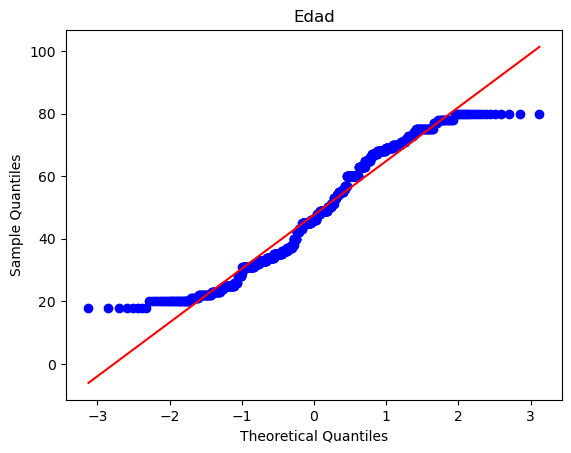

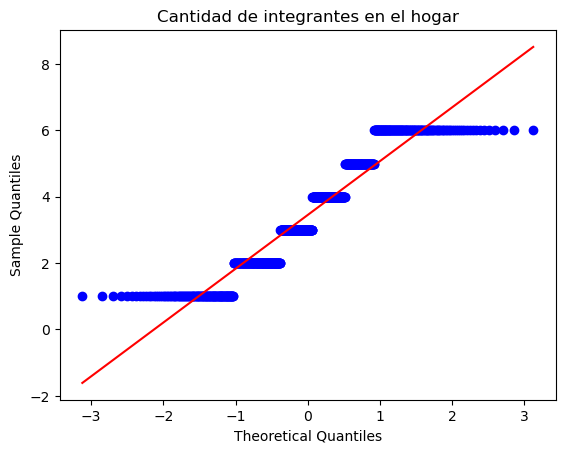

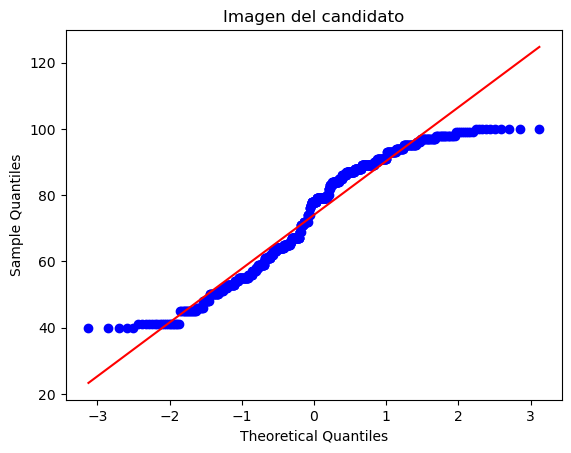

In [1269]:
# Vemos la distribucion de los datos para edad 
# Graficamos un Q-Q Plot (QQPlot) para la variable 'edad' del DataFrame ponderado.
# Este gráfico compara los cuantiles de la distribución de edad observada con los de una normal teórica.
# Si los puntos siguen aproximadamente una línea recta, indica que los datos se distribuyen de manera normal.
# Revisar la normalidad de los datos puede ser un paso previo al análisis de homocedasticidad (igualdad de varianzas).
stats.probplot(df_ponderado["edad"], dist="norm", plot=plt)
plt.title("Edad")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

# Vemos la distribucion de los datos para cantidad de integrantes en el hogar #
stats.probplot(df_ponderado["cantidad_de_integrantes_en_el_hogar"], dist="norm", plot=plt)
plt.title("Cantidad de integrantes en el hogar")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

# vemos la distribucion de los datos para la imagen del candidato

stats.probplot(df_ponderado["imagen_del_candidato"], dist="norm", plot=plt)
plt.title("Imagen del candidato")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()


In [ ]:
from scipy.stats import shapiro, kstest
data_para_test = df_ponderado ["edad"]
data_para_test
# Testeamos la normalidad de la variable 'edad' usando la prueba de Shapiro-Wilk.
# Usamos groupby para agrupar los datos por 'sexo' y luego aplicamos stats.shapiro a cada grupo.
# Esto permite verificar si la variable 'edad' sigue una distribución normal dentro de cada grupo (mujeres y varones).
# El resultado incluye la estadística W y el p-value para cada grupo.

0      77
1      22
2      34
3      56
4      35
       ..
768    46
769    49
770    49
771    31
772    73
Name: edad, Length: 773, dtype: Int64

In [1271]:
# Test de Shapiro - Wilk 
# Si los puntos siguen aproximadamente una línea recta(valor cerca de 1), indica que los datos se distribuyen de manera normal.
shapiro_test = shapiro(data_para_test)
print(f"Shapiro-Wilk test: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
#Si el p-value es menor a 0.05, rechazamos la hipótesis nula de normalidad.

Shapiro-Wilk test: W=0.9543692381448192, p-value=9.489964621098898e-15


In [1272]:
# Aplicamos la prueba de normalidad Kolmogorov-Smirnov (KS) a la variable 'edad'.(Muestras más grandes)
# Esta prueba compara la distribución acumulada de los datos observados con la de una distribución normal teórica(en este caso, usando la media y desviación estándar muestral).
# La estadística D mide la máxima diferencia entre vertical absoluta entre la función de distribución acumulada (FDA) empírica de tus datos y la FDA de la distribución de referencia
# El p-value indica el nivel de significancia. Si es < 0.05, se rechaza la hipótesis nula de que los datos provienen de una normal

ks_test = kstest(data_para_test, 'norm', args=(np.mean(data_para_test), np.std(data_para_test)))
print(f"Kolmogorov-Smirnov test: D={ks_test.statistic}, p-value={ks_test.pvalue}")

Kolmogorov-Smirnov test: D=0.10670158117110767, p-value=4.059959767503868e-08


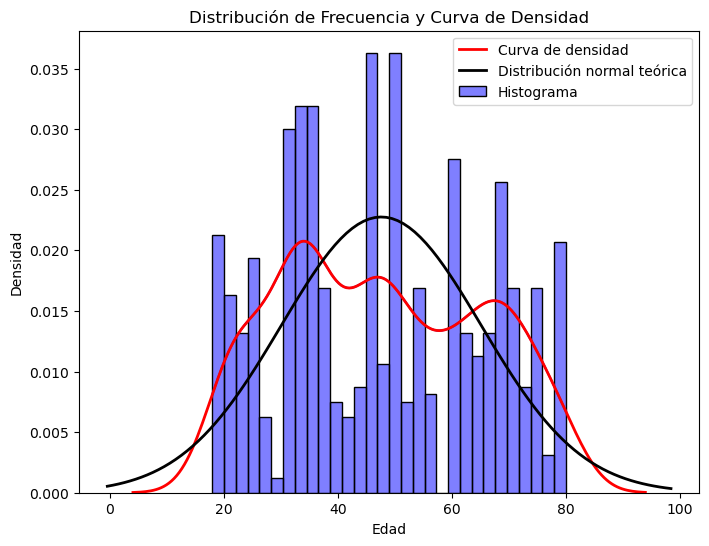

In [1273]:
# Plot de la distribución de frecuencia con histograma y curva de densidad
plt.figure(figsize=(8,6))

# Histograma con curva de densidad que es una estimación de la distribución de los datos
sns.histplot(data_para_test, kde=True, stat="density", color="blue", bins=30, label="Histograma") #histograma de los datos
sns.kdeplot(data_para_test, color="red", lw=2, label="Curva de densidad") #curva de densidad estimada a partir de los datos

# Añadir la curva de una distribución normal teórica para comparar con los datos
xmin, xmax = plt.xlim() # límites del eje x
x = np.linspace(xmin, xmax, 100) # rango de valores x
p = stats.norm.pdf(x, np.mean(data_para_test), np.std(data_para_test)) # distribución normal teórica
plt.plot(x, p, 'k', lw=2, label="Distribución normal teórica")

# Personalización del gráfico  
plt.title('Distribución de Frecuencia y Curva de Densidad')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.legend()

plt.show()

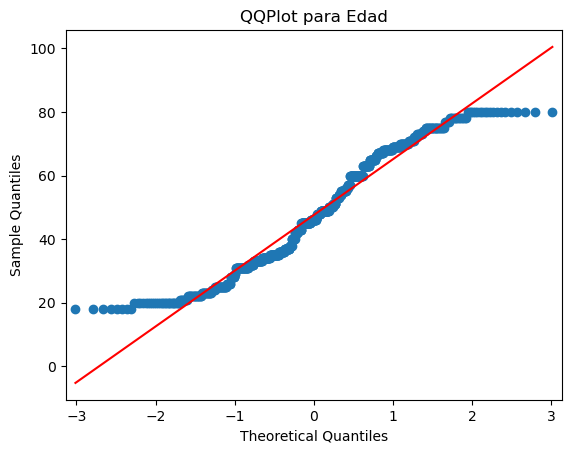

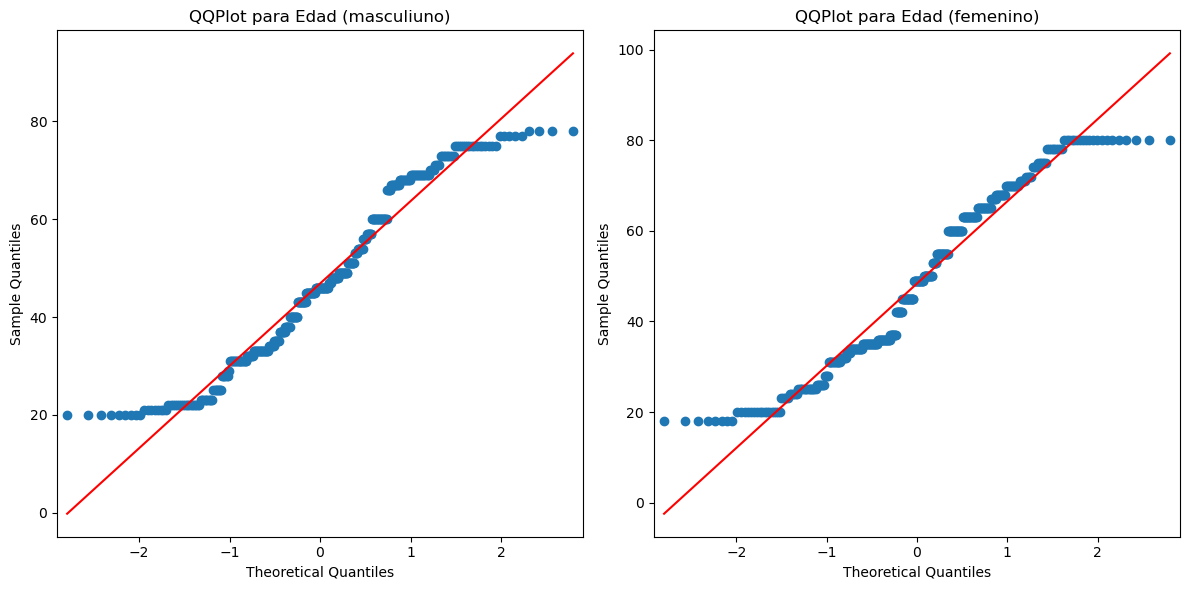

In [1274]:
#Homocedasticidad en las variables 
import pingouin as pg
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

#Volvemos a utilizar el dataframe de encuestas ponderado
qqplot(df_ponderado['edad'], line='s') 
plt.title("QQPlot para Edad")
plt.show()

#Filtrar los datos por sexo
ejercicio_mujer = df_ponderado[df_ponderado['sexo'] == 'femenino']['edad']
ejercicio_varon = df_ponderado[df_ponderado['sexo'] == 'masculino']['edad']

# Crear la figura para los dos QQPlots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# QQPlot para mujeres
sm.qqplot(ejercicio_mujer, line='s', ax=axes[0])
axes[0].set_title("QQPlot para Edad (masculiuno)")

# QQPlot para varones
sm.qqplot(ejercicio_varon, line='s', ax=axes[1])
axes[1].set_title("QQPlot para Edad (femenino)")

plt.tight_layout()
plt.show()


In [1275]:
# Testeamos la normalidad de la variable 'edad' en cada grupo de 'sexo' por separado usando la prueba de Shapiro-Wilk.
# Usamos groupby para agrupar los datos por 'sexo' y luego aplicamos stats.shapiro a cada grupo.
# Esto permite verificar si la variable 'edad' sigue una distribución normal dentro de cada grupo (mujeres y varones).
# El resultado incluye la estadística W y el p-value para cada grupo.
# para el testeo de normalidad por grupo utilizando funciones
shapiro_test_sexo = df_ponderado.groupby('sexo')['edad'].apply(stats.shapiro)
print("Shapiro-Wilk test para edad por sexo:")
shapiro_test_sexo

Shapiro-Wilk test para edad por sexo:


sexo
femenino      (0.9492794134991138, 3.315972966883279e-10)
masculino    (0.9477658644153181, 1.7400992375567443e-10)
Name: edad, dtype: object

Al ser cercano a uno la distribución es normal

# 6.6 Regresión Lineal #

Text(0, 0.5, 'imagen_del_candidato')

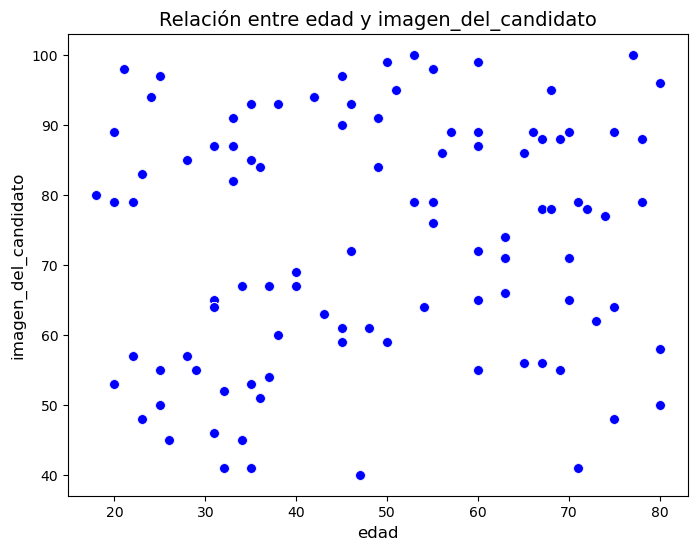

In [1276]:
#Regresion Lineal entre edad e imagen del candidato
#Clonamos el dataframe ponderado para regresion
encuesta_regresion = df_ponderado
#usamos las variables edad e imagen del candidato
x_var = 'edad'
y_var = 'imagen_del_candidato'
# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=encuesta_regresion[x_var], y=encuesta_regresion[y_var], s=50, color='blue')

# Etiquetas y título del gráfico
plt.title(f'Relación entre {x_var} y {y_var}', fontsize=14)
plt.xlabel(x_var, fontsize=12)
plt.ylabel(y_var, fontsize=12)

In [1277]:
# Calculamos la correlación de Pearson entre las variables 'x_var' y 'y_var' del DataFrame 'encuesta_regresion'.
# La correlación de Pearson mide la relación lineal entre dos variables numéricas, con valores entre -1 y 1.
# Un valor cercano a 1 indica correlación positiva fuerte; cercano a -1, correlación negativa fuerte; y cercano a 0, poca o ninguna correlación lineal.
correlacion_pearson = encuesta_regresion[x_var].corr(encuesta_regresion[y_var])
print(f'Correlación de Pearson entre {x_var} y {y_var}: {correlacion_pearson:.2f}')

Correlación de Pearson entre edad y imagen_del_candidato: 0.11


In [1278]:
#Preparamos los datos para el modelo de regresión lineal
X_simple_edad = sm.add_constant(encuesta_regresion[x_var].astype(float)) #Añadimos constante sm.add_constant() agrega una columna de unos al DataFrame para incluir el intercepto en el modelo.
modelo_simple_edad = sm.OLS(encuesta_regresion[y_var], X_simple_edad).fit() #Ajustamos un modelo de regresión lineal (OLS: Ordinary Least Squares) para predecir 'y_var' a partir de 'x_var'. El método .fit() ajusta el modelo a los datos.

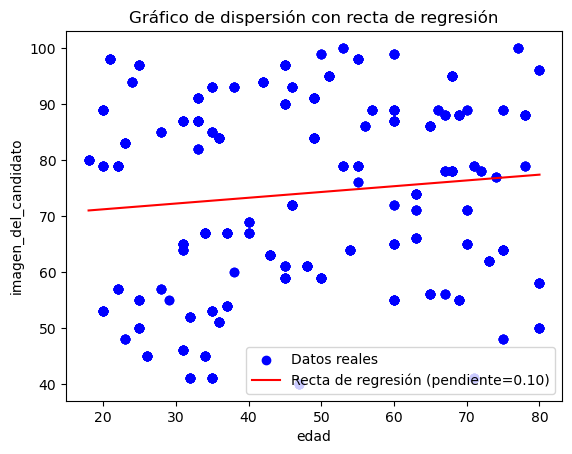

In [1279]:
# Generar la recta de regresión
plt.scatter(encuesta_regresion[x_var], encuesta_regresion[y_var], label='Datos reales', color='blue')
# Graficamos el diagrama de dispersión (scatter plot) de las variables independientes y dependientes para visualizar su relación.
intercepto, pendiente = modelo_simple_edad.params # Obtenemos los parámetros del modelo de regresión lineal: intercepto y pendiente.
x_vals = np.linspace(encuesta_regresion[x_var].min(), encuesta_regresion[x_var].max(), 100)
y_vals = intercepto + pendiente * x_vals

# Dibujar la recta de regresión en el gráfico de dispersión
plt.plot(x_vals, y_vals, color='red', label=f'Recta de regresión (pendiente={pendiente:.2f})') #Creamos valores de x en el rango de la variable independiente para dibujar la recta de regresión.


#Personalizar el gráfico
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.title('Gráfico de dispersión con recta de regresión')
plt.legend()

# Mostrar el gráfico final
plt.show()


In [1280]:
print(modelo_simple_edad.summary()) #Mostramos el resumen estadístico del modelo de regresión lineal ajustado, que incluye coeficientes, R-cuadrado, valores p, entre otros.

                             OLS Regression Results                             
Dep. Variable:     imagen_del_candidato   R-squared:                       0.012
Model:                              OLS   Adj. R-squared:                  0.011
Method:                   Least Squares   F-statistic:                     9.211
Date:                  mar, 25 nov 2025   Prob (F-statistic):            0.00249
Time:                          18:44:50   Log-Likelihood:                -3266.0
No. Observations:                   773   AIC:                             6536.
Df Residuals:                       771   BIC:                             6545.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.1177      1.725

In [1281]:
# Regresion lineal entre sexo e imagen del candidato
df_regresion_sexo = df_ponderado.copy() #clonamos el df ponderado
# Convertimos la variable categórica 'sexo' en una variable numérica para regresión lineal
df_regresion_sexo ['sexo_numerico'] = df_regresion_sexo['sexo'].map({'femenino': 0, 'masculino': 1})
print(df_regresion_sexo[['sexo', 'sexo_numerico']].head())
print(df_regresion_sexo[['sexo_numerico']].dtypes)

        sexo  sexo_numerico
0   femenino              0
1   femenino              0
2  masculino              1
3   femenino              0
4  masculino              1
sexo_numerico    int64
dtype: object


Text(0, 0.5, 'sexo_numerico')

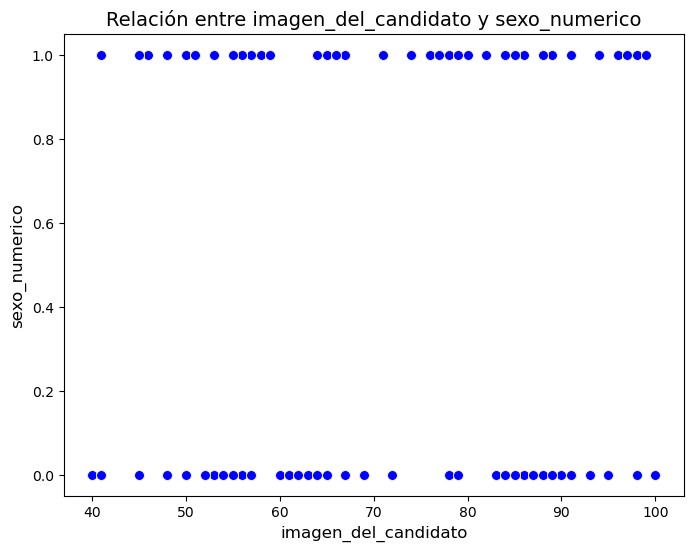

In [1282]:
# Establecemos las variables imagen del candidato y sexo numerico
x_var_2 = 'imagen_del_candidato'
y_var_2 = 'sexo_numerico'

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_regresion_sexo[x_var_2], y=df_regresion_sexo[y_var_2], s=50, color='blue')

# Etiquetas y título del gráfico
plt.title(f'Relación entre {x_var_2} y {y_var_2}', fontsize=14)
plt.xlabel(x_var_2, fontsize=12)
plt.ylabel(y_var_2, fontsize=12)

In [1283]:
#Calcular la correlación de Pearson
correlacion_pearson = df_regresion_sexo[x_var_2].corr(df_regresion_sexo[y_var_2]) #Calculamos la correlación de Pearson entre imagen del candidato y sexo.
print(f'Correlación de Pearson entre {x_var_2} y {y_var_2}: {correlacion_pearson:.2f}')

Correlación de Pearson entre imagen_del_candidato y sexo_numerico: -0.02


In [1284]:
#Ajustar el modelo de regresión lineal
X_simple_sexo = sm.add_constant(df_regresion_sexo[x_var_2]).astype(float)  # Añadir la constante
modelo_simple_sexo = sm.OLS(df_regresion_sexo[y_var_2], X_simple_sexo).fit()

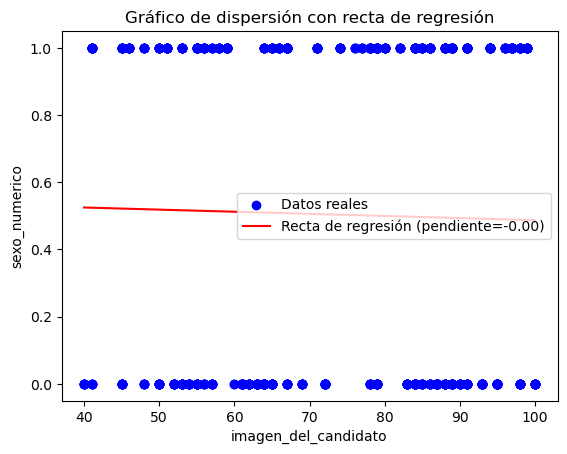

In [1285]:
# Generar la recta de regresión
plt.scatter(df_regresion_sexo[x_var_2], df_regresion_sexo[y_var_2], label='Datos reales', color='blue')

intercepto, pendiente = modelo_simple_sexo.params #intercepto es ordenada al origen y pendiente es la inclinación de la recta
x_vals = np.linspace(df_regresion_sexo[x_var_2].min(), df_regresion_sexo[x_var_2].max(), 100)
y_vals = intercepto + pendiente * x_vals

# Dibujar la recta de regresión en el gráfico de dispersión
plt.plot(x_vals, y_vals, color='red', label=f'Recta de regresión (pendiente={pendiente:.2f})')

#Personalizar el gráfico
plt.xlabel(x_var_2)
plt.ylabel(y_var_2)
plt.title('Gráfico de dispersión con recta de regresión')
plt.legend()

# Mostrar el gráfico final
plt.show()

In [1286]:
print(modelo_simple_sexo.summary())

                            OLS Regression Results                            
Dep. Variable:          sexo_numerico   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3375
Date:                mar, 25 nov 2025   Prob (F-statistic):              0.561
Time:                        18:44:51   Log-Likelihood:                -560.85
No. Observations:                 773   AIC:                             1126.
Df Residuals:                     771   BIC:                             1135.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5497 

In [1287]:
#Regresion Lineal 3 entre edad y nivel educativo
df_regresion_educacion = df_ponderado.copy() #clonamos el df ponderado
print(df_regresion_educacion["nivel_educativo"].unique()) #vemos los niveles educativos unicos
df_regresion_educacion['nivel_educativo_numerico'] = df_regresion_educacion['nivel_educativo'].map({"Primario incompleto": 1,
                                                                                                    "Primario completo": 2,
                                                                                                    "Secundario incompleto": 3,
                                                                                                    "Secundario completo": 4,
                                                                                                    "Terciario/Universitario incompleto": 5,
                                                    "Terciario/Universitario completo": 6,
                                                    "Posgrado": 7,
                                                    "universitario completo": 8})
print(df_regresion_educacion[['nivel_educativo', 'nivel_educativo_numerico']].head())


['Terciario/Universitario completo' 'Terciario/Universitario incompleto'
 'Primario incompleto' 'Secundario incompleto' 'Secundario completo'
 'Posgrado' 'Primario completo']
                      nivel_educativo  nivel_educativo_numerico
0    Terciario/Universitario completo                         6
1  Terciario/Universitario incompleto                         5
2                 Primario incompleto                         1
3               Secundario incompleto                         3
4               Secundario incompleto                         3


In [1288]:
print(df_regresion_educacion[['nivel_educativo_numerico']].dtypes)

nivel_educativo_numerico    int64
dtype: object


Text(0, 0.5, 'imagen_del_candidato')

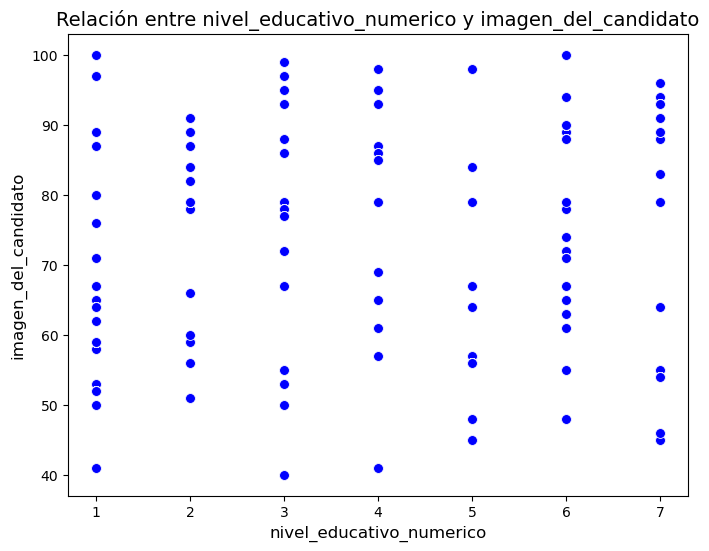

In [1289]:
# Establecemos las varaibles imagen del candidato y sexo numerico
x_var_3 = 'nivel_educativo_numerico'
y_var_3 = 'imagen_del_candidato'

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_regresion_educacion[x_var_3], y=df_regresion_educacion[y_var_3], s=50, color='blue')

# Etiquetas y título del gráfico
plt.title(f'Relación entre {x_var_3} y {y_var_3}', fontsize=14)
plt.xlabel(x_var_3, fontsize=12)
plt.ylabel(y_var_3, fontsize=12)

In [1290]:
#Calcular la correlación de Pearson
correlacion_pearson = df_regresion_educacion[x_var_3].corr(df_regresion_educacion[y_var_3]) 
print(f'Correlación de Pearson entre {x_var_3} y {y_var_3}: {correlacion_pearson:.2f}')

Correlación de Pearson entre nivel_educativo_numerico y imagen_del_candidato: 0.07


In [1291]:
#Ajustar el modelo de regresión lineal
X_simple_educacion = sm.add_constant(df_regresion_educacion[x_var_3]).astype(float)  #Añadir la constante
modelo_simple_educacion= sm.OLS(df_regresion_educacion[y_var_3], X_simple_educacion).fit() #Ajustamos el modelo de regresión lineal

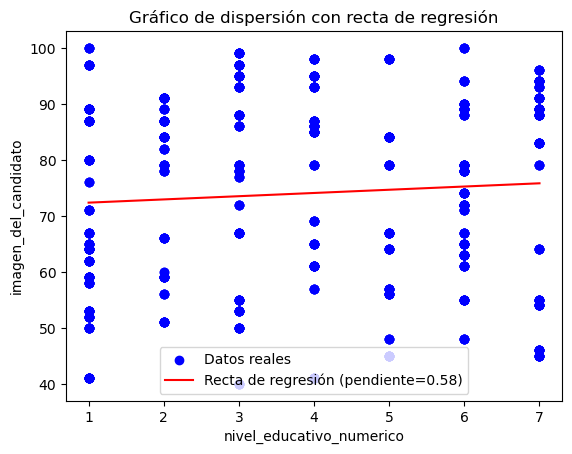

In [ ]:
# Generar la recta de regresión
plt.scatter(df_regresion_educacion[x_var_3], df_regresion_educacion[y_var_3], label='Datos reales', color='blue')


intercepto, pendiente = modelo_simple_educacion.params 
x_vals = np.linspace(df_regresion_educacion[x_var_3].min(), df_regresion_educacion[x_var_3].max(), 100) #rango de valores x
y_vals = intercepto + pendiente * x_vals #calculamos los valores y de la recta de regresion

# Dibujar la recta de regresión en el gráfico de dispersión
plt.plot(x_vals, y_vals, color='red', label=f'Recta de regresión (pendiente={pendiente:.2f})') #creamos valores de x en el rango de la variable independiente para dibujar la recta de regresión.

#Personalizar el gráfico
plt.xlabel(x_var_3)
plt.ylabel(y_var_3)
plt.title('Gráfico de dispersión con recta de regresión')
plt.legend()

# Mostrar el gráfico final
plt.show()

In [1293]:
print(modelo_simple_educacion.summary())

                             OLS Regression Results                             
Dep. Variable:     imagen_del_candidato   R-squared:                       0.005
Model:                              OLS   Adj. R-squared:                  0.004
Method:                   Least Squares   F-statistic:                     4.013
Date:                  mar, 25 nov 2025   Prob (F-statistic):             0.0455
Time:                          18:44:51   Log-Likelihood:                -3268.6
No. Observations:                   773   AIC:                             6541.
Df Residuals:                       771   BIC:                             6551.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
cons

Text(0, 0.5, 'edad')

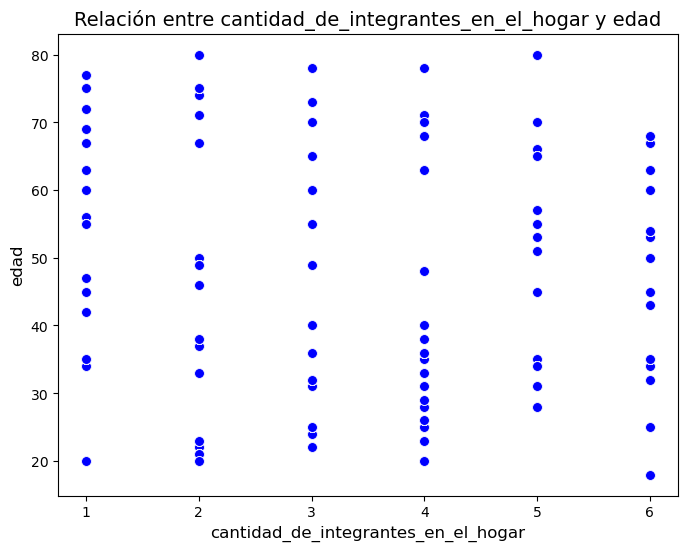

In [1294]:
# Regresion lineal 4 entre cantidad de integrantes en el hogar e imagen del candidato
df_regresion_hogar = df_ponderado.copy()
#usamos las variables edad e imagen del candidato
x_var_4 = 'cantidad_de_integrantes_en_el_hogar'
y_var_4 = 'edad'
# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_regresion_hogar[x_var_4], y=df_regresion_hogar[y_var_4], s=50, color='blue')
# Etiquetas y título del gráfico
plt.title(f'Relación entre {x_var_4} y {y_var_4}', fontsize=14)
plt.xlabel(x_var_4, fontsize=12)
plt.ylabel(y_var_4, fontsize=12)

In [1295]:
#Calcular la correlación de Pearson
correlacion_pearson = df_regresion_hogar[x_var_4].corr(df_regresion_hogar[y_var_4])
print(f'Correlación de Pearson entre {x_var_4} y {y_var_4}: {correlacion_pearson:.2f}')


Correlación de Pearson entre cantidad_de_integrantes_en_el_hogar y edad: -0.09


In [1296]:
#Ajustar el modelo de regresión lineal
X_simple_hogar = sm.add_constant(df_regresion_hogar[x_var_4].astype(float))
modelo_simple_hogar = sm.OLS(df_regresion_hogar[y_var_4], X_simple_hogar).fit()

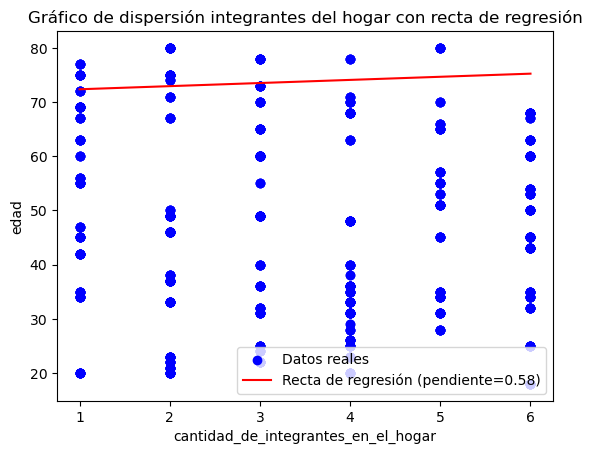

In [1297]:
# Generar la recta de regresión
plt.scatter(df_regresion_hogar[x_var_4], df_regresion_hogar[y_var_4], label='Datos reales', color='blue')


intercepto, pendiente = modelo_simple_educacion.params
x_vals = np.linspace(df_regresion_hogar[x_var_4].min(), df_regresion_hogar[x_var_4].max(), 100)
y_vals = intercepto + pendiente * x_vals

# Dibujar la recta de regresión en el gráfico de dispersión
plt.plot(x_vals, y_vals, color='red', label=f'Recta de regresión (pendiente={pendiente:.2f})')

#Personalizar el gráfico
plt.xlabel(x_var_4)
plt.ylabel(y_var_4)
plt.title('Gráfico de dispersión integrantes del hogar con recta de regresión')
plt.legend()

# Mostrar el gráfico final
plt.show()

In [1298]:
print(modelo_simple_hogar.summary())

                            OLS Regression Results                            
Dep. Variable:                   edad   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     6.915
Date:                mar, 25 nov 2025   Prob (F-statistic):            0.00872
Time:                        18:44:52   Log-Likelihood:                -3307.4
No. Observations:                 773   AIC:                             6619.
Df Residuals:                     771   BIC:                             6628.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

Text(0, 0.5, 'imagen_del_candidato')

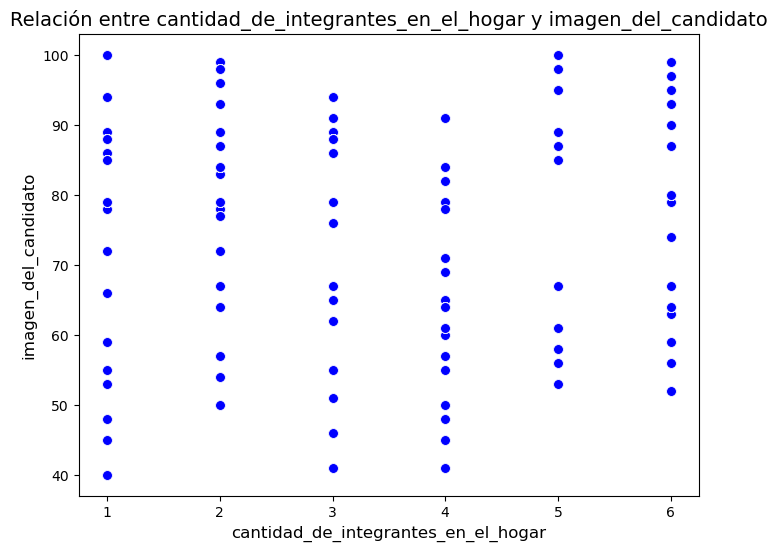

In [ ]:
# Regresion lineal 5  entre imagen del candidato y cantidad de integrantes en el hogar
df_regresion_candidato = df_ponderado.copy()
df_regresion_candidato
#usamos las variables edad e imagen del candidato
x_var_5 = 'cantidad_de_integrantes_en_el_hogar'
y_var_5 = 'imagen_del_candidato'
# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x= df_regresion_candidato[x_var_5], y=df_regresion_candidato[y_var_5], s=50, color='blue')
# Etiquetas y título del gráfico
plt.title(f'Relación entre {x_var_5} y {y_var_5}', fontsize=14)
plt.xlabel(x_var_5, fontsize=12)
plt.ylabel(y_var_5, fontsize=12)

In [1300]:
#Calcular la correlación de Pearson
correlacion_pearson = df_regresion_candidato[x_var_5].corr(df_regresion_candidato[y_var_5])
print(f'Correlación de Pearson entre {x_var_5} y {y_var_5}: {correlacion_pearson:.2f}')

Correlación de Pearson entre cantidad_de_integrantes_en_el_hogar y imagen_del_candidato: 0.06


In [1301]:
#Ajustar el modelo de regresión lineal
X_simple_candidato = sm.add_constant(df_regresion_candidato[x_var_5])
modelo_simple_candidato = sm.OLS(df_regresion_candidato[y_var_5], X_simple_candidato).fit()

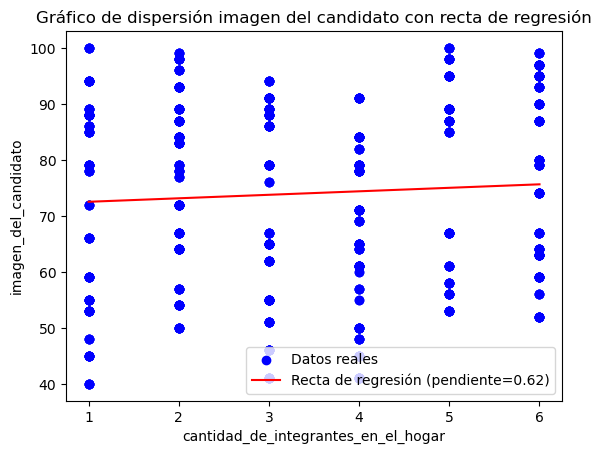

In [1302]:
# Generar la recta de regresión
plt.scatter(df_regresion_candidato[x_var_5], df_regresion_candidato[y_var_5], label='Datos reales', color='blue')


intercepto, pendiente = modelo_simple_candidato.params
x_vals = np.linspace(df_regresion_candidato[x_var_5].min(), df_regresion_candidato[x_var_5].max(), 100)
y_vals = intercepto + pendiente * x_vals

# Dibujar la recta de regresión en el gráfico de dispersión
plt.plot(x_vals, y_vals, color='red', label=f'Recta de regresión (pendiente={pendiente:.2f})')

#Personalizar el gráfico
plt.xlabel(x_var_5)
plt.ylabel(y_var_5)
plt.title('Gráfico de dispersión imagen del candidato con recta de regresión')
plt.legend()

# Mostrar el gráfico final
plt.show()

In [1303]:
print(modelo_simple_candidato.summary())

                             OLS Regression Results                             
Dep. Variable:     imagen_del_candidato   R-squared:                       0.004
Model:                              OLS   Adj. R-squared:                  0.003
Method:                   Least Squares   F-statistic:                     3.125
Date:                  mar, 25 nov 2025   Prob (F-statistic):             0.0775
Time:                          18:44:53   Log-Likelihood:                -3269.1
No. Observations:                   773   AIC:                             6542.
Df Residuals:                       771   BIC:                             6551.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------